In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
def vvv_format(title='', ylabel='', autoscale=False, min=0, max=1, legend=True):

    plt.grid()
    plt.xticks(np.arange(1, 35, 4))

    #plt.title(title, fontsize=14)
    plt.title(title)
    if legend:
        plt.legend()
    plt.xlabel('Session Number')
    if autoscale is False:
        plt.ylim(0, max)
    plt.ylabel(ylabel)
    plt.show()

plt.rcParams['figure.figsize'] = 12, 8
    
fontsize = 20
font = {'family' : 'sans-serif',
    'weight' : 'normal',
    'size'   : fontsize}

matplotlib.rc('font', **font)
matplotlib.rc('lines', lw=6)

COLORS = {
    'CHI': 'tab:blue',
    'MOT': 'tab:orange'
}

In [4]:
%%time 

# load the data

store = pd.HDFStore('ngram-data.h5')
grams = store['ngram_data']
grams = grams[~pd.isnull(grams.ngram)]

CPU times: user 4.9 s, sys: 633 ms, total: 5.53 s
Wall time: 5.53 s


In [6]:
def morisita(a, b, drop_zeros=False, randomize=False):
    if randomize:
        b.index = np.random.permutation(b.index)
    if drop_zeros:
        df = pd.DataFrame({'a': a, 'b': b}).dropna(how='any')
        a, b = df.a, df.b
    else:
        a, b = a.align(b, fill_value=0)
    a = a / a.sum()
    b = b / b.sum()
    numer = np.dot(a, b)
    denom = np.square(a).sum() + np.square(b).sum()
    return 2 * numer / denom

def morisita_child_adult(df, drop_zeros=False):
    child = df[df.speaker.eq('CHI')].ngram.value_counts()
    adult = df[df.speaker.eq('MOT')].ngram.value_counts()
    return morisita(child, adult, drop_zeros=drop_zeros)

def morisita_adult_adult(df, corpus1, corpus2):
    adult1 = df[df.speaker.eq('MOT') & df.corpus.eq(corpus1)].ngram.value_counts()
    adult2 = df[df.speaker.eq('MOT') & df.corpus.eq(corpus2)].ngram.value_counts()
    return morisita(adult1, adult2)


In [29]:
pairs = [(x, y)
    for x, y in combinations(grams.corpus.unique(), 2)
    if x != y]

In [104]:
sessions = grams.session.unique()
output = []
names = grams.corpus.unique()
for child in names:
    print(child)
    for adult in names:
        if child == adult: 
            continue
        for session in grams.session.unique():
            sf = grams.session.eq(session)
            try:
                m = morisita_child_adult(
                    pd.concat([
                        grams[sf & grams.speaker.eq('CHI') & grams.corpus.eq(child)],
                        grams[sf & grams.speaker.eq('MOT') & grams.corpus.eq(adult)]]))
            except Exception as e:
                print('error', e)
            output.append((child, adult, session, m))

anne
aran
becky
carl
domin
gail
joel
john


/home/paul/.virtualenvs/formulae/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


liz
nic
ruth
warr


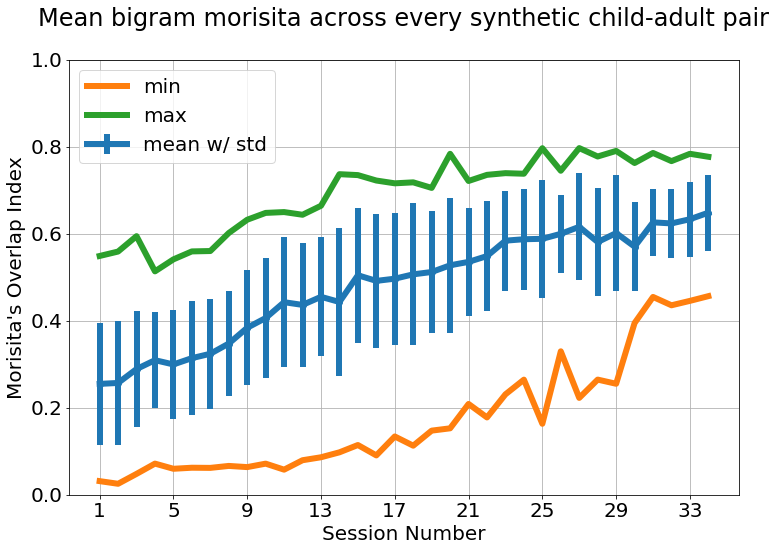

In [118]:
df = pd.DataFrame(output, columns=['child', 'adult', 'session', 'morisita'])
df['corpus'] = df.child + '-' + df.adult
del df['child']
del df['adult']
stats = df.pivot('corpus', 'session').aggregate(['mean', 'std', 'min', 'max']).morisita.T
plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
plt.plot(stats.index, stats['min'])
plt.plot(stats.index, stats['max'])
plt.ylim(0, 1)
vvv_format('Mean bigram morisita across every synthetic child-adult pair\n', ylabel="Morisita's Overlap Index")